# model explanations

Here we explain the linear model's predictions using Shap explanation methods.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
# import pickle 
from tqdm import tqdm

# explanation tools
import shap

# plotting/visualizations
import sklearn as skl

import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 9
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-02-20 13:36:53.246801: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-20 13:36:55.060231: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-20 13:36:55.085826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-20 13:36:55.086017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-20 13:36:55.086047: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

In [2]:
tf.__version__

'2.5.0'

## load the data and the trained model

In [3]:
# data
test_file = f"{proj_dir}/data/emoprox2/test_dataframe.pkl"
test_df = pd.read_pickle(test_file)
display(test_df)

X, y = prepare_data_for_model(df=test_df)

# model
model_file = f"{results_dir}/models/linear_model"
linear_model = tf.keras.models.load_model(model_file)

linear_model.summary()

,X,y,mask
0,"[[0.512918, 0.547141, 0.100542, 0.026633, 1.50...","[0.3019871606242329, 0.3593604239884513, 0.416...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[[-0.035273, -0.234579, -0.66522, -0.571048, -...","[0.4512517163194395, 0.403617813223693, 0.3560...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[[-0.063699, -0.185546, 0.006985, -0.06872, -0...","[0.4950820412729392, 0.4406881501898595, 0.380...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
3,"[[0.212841, 0.070608, -0.048758, 0.043117, -0....","[0.348026457813505, 0.399483037414988, 0.45071...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[[-0.278475, 0.024222, 0.930903, 0.133013, -0....","[0.4991469039553821, 0.441531815585027, 0.3806...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
64,"[[-0.058707, -0.34063, -1.171228, 0.004106, -0...","[0.4512517163194395, 0.403617813223693, 0.3560...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
65,"[[0.116604, -0.237293, -0.015429, -0.034826, -...","[0.4950820412729392, 0.4406881501898595, 0.380...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
66,"[[-0.44084, -0.046966, -1.170635, 0.289755, -0...","[0.348026457813505, 0.399483037414988, 0.45071...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
67,"[[0.409907, -0.082538, -1.07226, -0.206831, -0...","[0.4991469039553821, 0.441531815585027, 0.3806...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


2022-02-20 13:36:55.585947: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 13:36:55.587088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-20 13:36:55.587433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2022-02-20 13:36:55.587481: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-20 13:36:55.962311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect St

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 85)]              0         
_________________________________________________________________
masking (Masking)            (None, 85)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 86        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


## explanations

### data for explaining the model

In [4]:
# x, y = prepare_data_for_model(test_df[:1], shuffle=False)
x = np.concatenate(test_df[:1]['X'].tolist())
y = np.concatenate(test_df[:1]['y'].tolist())

### shap: GradientExplainer

In [5]:
# select a set of background examples to take an expectation over
background = shap.utils.sample(X, nsamples=50)
# background.shape

gradient_explainer = shap.GradientExplainer(linear_model, background)

In [6]:
shap_values_gradient = gradient_explainer.shap_values(x)

2022-02-20 13:36:56.306880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-20 13:36:56.619423: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2022-02-20 13:36:56.681932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-20 13:36:56.700076: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


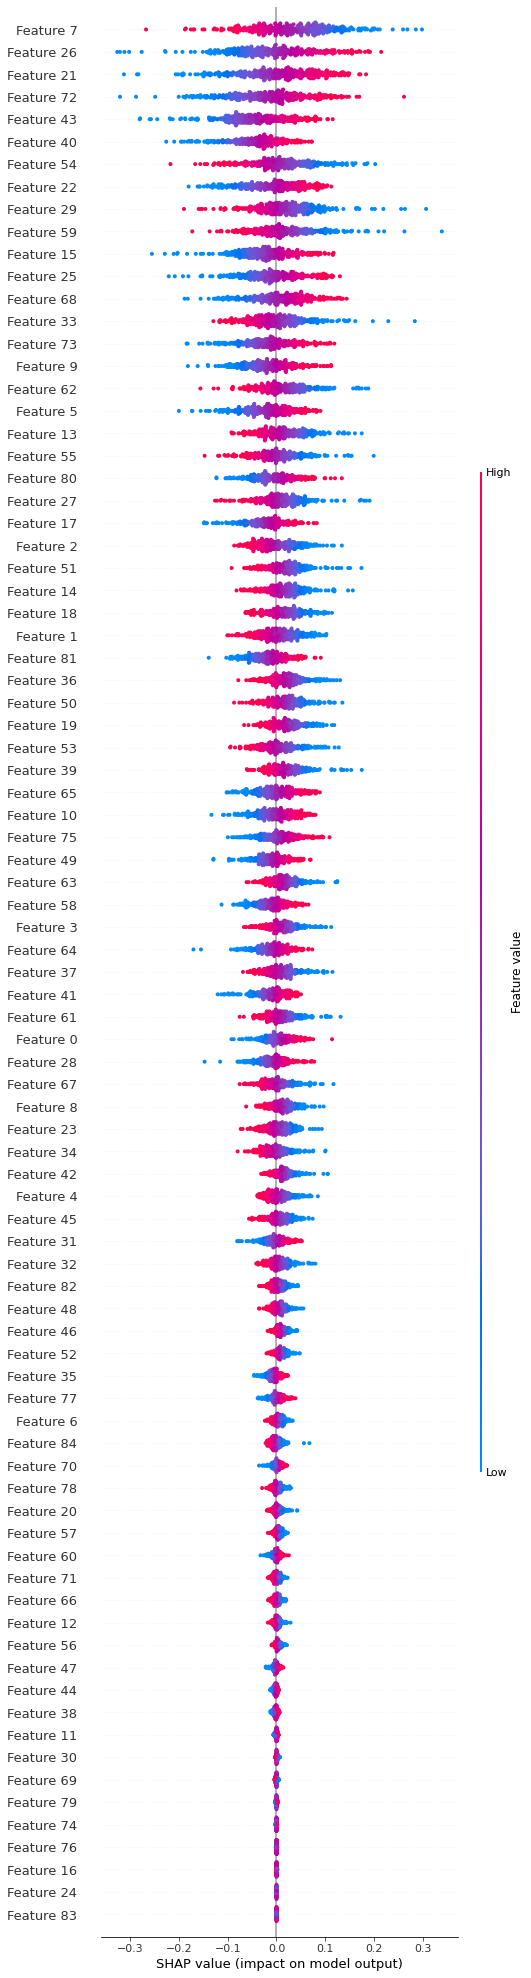

In [7]:
shap.summary_plot(shap_values_gradient[0], x, max_display=x.shape[-1])

### shap: KernelExplainer

In [ ]:
# select a set of background examples to take an expectation over
# 50 'typical' feature values
background = shap.utils.sample(X, nsamples=50)
# background.shape

kernel_explainer = shap.KernelExplainer(linear_model, background)

# 500 perturbation samples over the typical values to compute shap values for the given dataset.
shap_values_kernel = kernel_explainer.shap_values(x, nsamples=500)

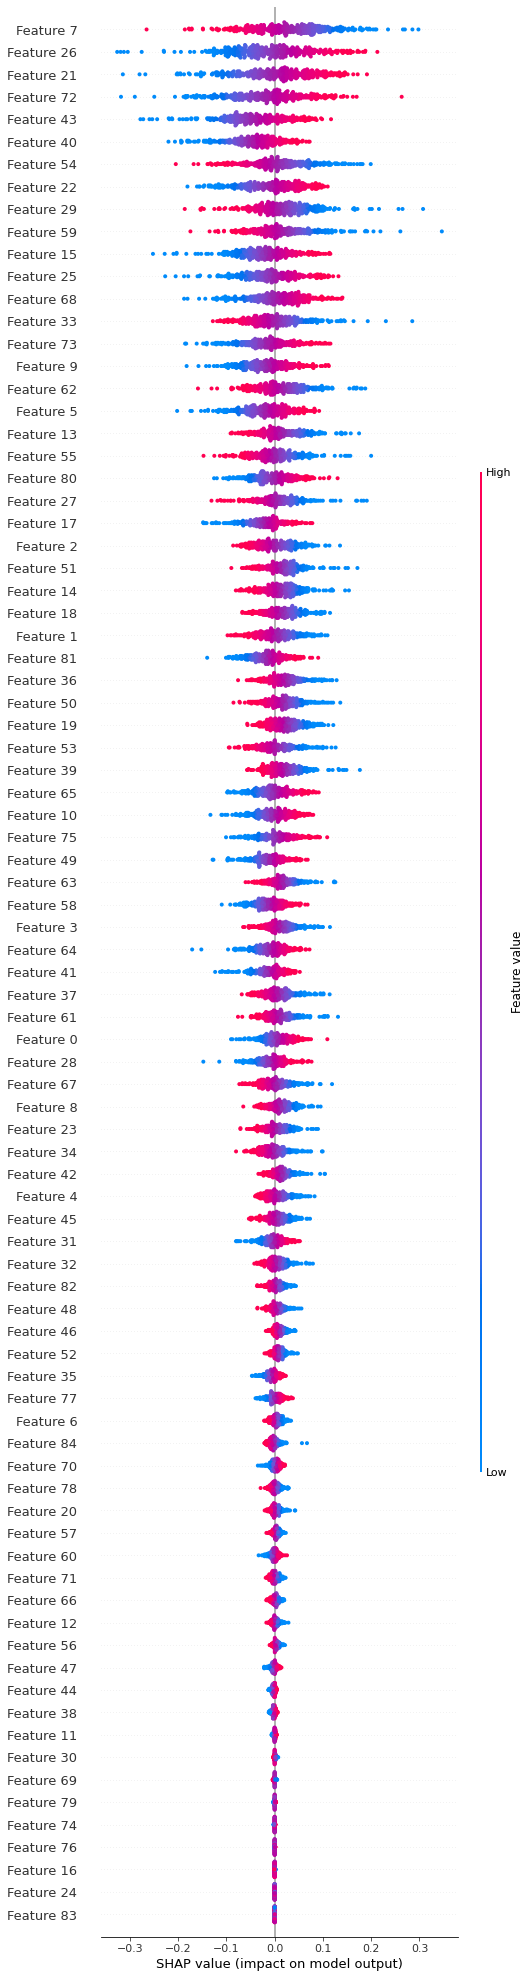

In [9]:
shap.summary_plot(shap_values_kernel[0], x, max_display=x.shape[-1])